In [182]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time;  from datetime import datetime
plt.rcParams["figure.figsize"] = (15,10)

In [ ]:
# this will have to come from overall function call. It is the difference in local time from PST.
offset_from_pst = 3

In [2]:
nyc = pd.read_csv('gapi_city_data-export-2017-11-30.csv') # read the gapi database
nyc.dropna(axis=1, how='all', inplace=True) # drops all columns where all values are NaN
nyc.drop("Organic Searches", axis=1,inplace=True) # Drops Column
nyc = nyc.loc[nyc['City'] == 1023191] # Selects records only NYC

In [3]:
weather = pd.read_csv('open_weather_6cities.csv')  # read the weather database
weather.dropna(axis=1, how='all', inplace=True) # drops all columns where all values are NaN
weather = weather.loc[weather['city_id'] == 5128581] # Selects records only NYC

In [313]:
##Join tables on Unix Time and return df


# takes a string  in YYYMMDDHH (nyc(Date Hour)) and returns a Unix Time assuming local time zone for input
# this works because (local time on my machine) == (timezone of ga: time{set by ga account preferences}) 
def unixtimestamp(row):
    return int(int(time.mktime(datetime.strptime(row, "%Y%m%d%H").timetuple())))

# creates new column unix_time in nyc using unixtimestamp
nyc['unix_time'] = nyc.apply(lambda row: unixtimestamp(str(row['Date Hour'])), axis=1)

# join nyc to weather on unix_time 
df = nyc.join(weather.set_index('dt'), on='unix_time') 

In [314]:
#TODO: remove the need for this fix by importing fresh city data.

# fix to drop rows where no weather data
df = df.dropna(subset=['temp'])

In [315]:
## Remove nighttime records

# night starts at 1 a.m,ends at 7 a.m. These hard coded values come from client.
night_start = 1
night_end = 6

# Adds hour column with only last two digits from Date Hour
df['Hour'] = df['Date Hour'].transform(str).str.slice(start=8).transform(int)

# function that given target city timezone offset from pst,
#returns start and end hours for the night in terms of pst
def offset_night_times(night_time,pst_offest):
    # if start/end time in pst is premidnight
    if night_time - pst_offest < 0:
        offset_night_time = 24 + night_time - pst_offest
    else:
        offset_night_time = night_time - pst_offest
    return (offset_night_time)

# calls above function and saves start and end of night in local time.
offset_night_start = offset_night_times(night_start,offset_from_pst)
offset_night_end = offset_night_times(night_end,offset_from_pst)

# drops night time values from df. if statement to accommdate possibility that target city night
# start is premidnight local time
def remove_night_hours_df():
    if offset_night_start>offset_night_end:
        df.drop(df[(df.Hour >= 22) | (df.Hour<= 3)].index, inplace=True)
    else:
        df.drop(df[(df.Hour >= 1) & (df.Hour<= 6)].index, inplace=True)

remove_night_hours_df()

assert df['Hour'].nunique() == 18

In [316]:
# Set desktop, tablet = desklet
df.loc[:,('Device Category')] = df.loc[:,('Device Category')].replace(to_replace=['desktop','tablet'],value='desklet')

In [317]:
df.head()

,City,Date Hour,User Type,Device Category,Sessions,Bounces,Users,Transactions,Transaction Revenue,Revenue Per User,...,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon,Hour
5903,1023191,2017070207,New Visitor,desklet,2,1,2,0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,800.0,Clear,Sky is Clear,01d,7
5904,1023191,2017070207,New Visitor,mobile,5,2,5,0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,800.0,Clear,Sky is Clear,01d,7
5905,1023191,2017070207,New Visitor,desklet,3,1,3,0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,800.0,Clear,Sky is Clear,01d,7
5906,1023191,2017070207,Returning Visitor,mobile,3,1,2,0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,800.0,Clear,Sky is Clear,01d,7
5907,1023191,2017070207,Returning Visitor,desklet,1,0,1,0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,800.0,Clear,Sky is Clear,01d,7


In [318]:
# Select columns 
df2= df[["User Type",'Device Category','Sessions','Transactions', 'Revenue Per User','temp','weather_id']]

In [319]:
(df2.head())

,User Type,Device Category,Sessions,Transactions,Revenue Per User,temp,weather_id
5903,New Visitor,desklet,2,0,0.0,296.843,800.0
5904,New Visitor,mobile,5,0,0.0,296.843,800.0
5905,New Visitor,desklet,3,0,0.0,296.843,800.0
5906,Returning Visitor,mobile,3,0,0.0,296.843,800.0
5907,Returning Visitor,desklet,1,0,0.0,296.843,800.0


In [320]:
def return_first_digit(row): # takes an int, returns first character as a string
    return (str(row)[0])
# remove all but the first unit of weather_id int
df2['weather_id'] = df2.loc[:,('weather_id')].apply(return_first_digit)

/home/dj/programming/data_env/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [321]:
df3 = df2.drop(['Sessions','Transactions'],axis=1)

In [322]:
weather_id_dict = {'2':'2 Thunderstorms','3':'3 Drizzle','5':'5 Rain','6':'6 Snow','7':'7 Atmosphere','8':'8 Clear','9':'9 Extreme'}

In [323]:
df3 = df3.replace({'weather_id':weather_id_dict}) 

In [324]:
df4 = df3.pivot_table(index='User Type', columns='weather_id',values='Revenue Per User', aggfunc=np.average)

In [325]:
df4

weather_id,2 Thunderstorms,3 Drizzle,5 Rain,6 Snow,7 Atmosphere,8 Clear
User Type,,,,,,
New Visitor,1.055845,1.295563,0.951011,1.110757,0.839407,0.908458
Returning Visitor,2.739967,3.163282,1.927571,2.399073,1.878682,1.985445


In [326]:
#df4=df4[df4.iloc[-1,:].sort_values(ascending=False).index]


Text(3.5,2.5,'Data without nighttime info')

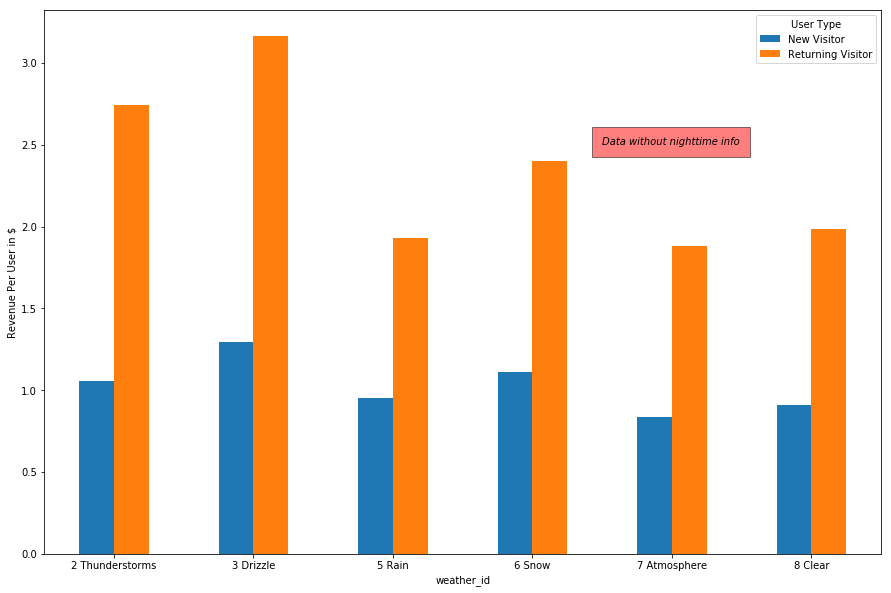

In [327]:
### Average Revenue per customer 
d = df4.transpose().plot.bar()
plt.ylabel('Revenue Per User in $')
plt.xticks(rotation='horizontal')
plt.text(3.5,2.5,  'Data without nighttime info', style='italic',
        bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})

Text(3.5,2.5,'Data with nighttime info')

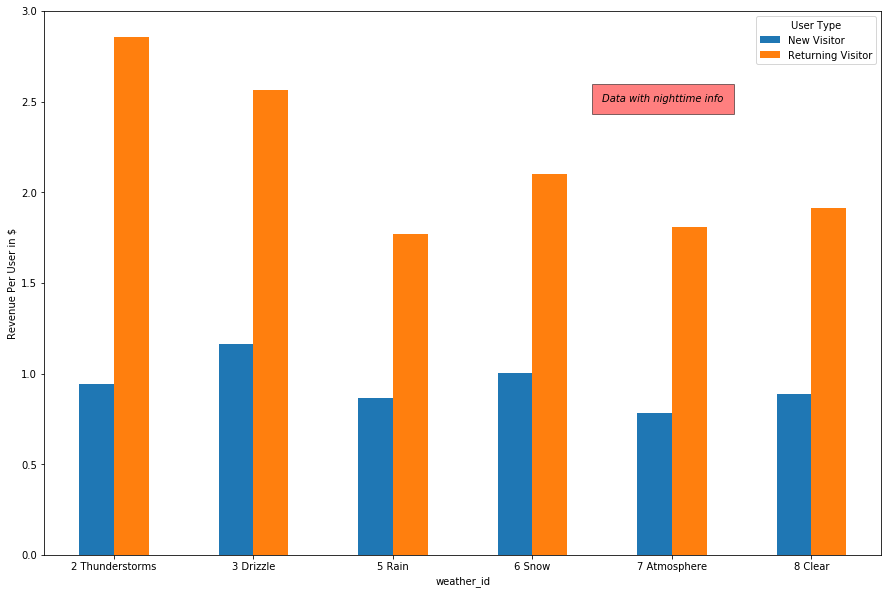

In [310]:
### Average Revenue per customer 
d = df4.transpose().plot.bar()
plt.ylabel('Revenue Per User in $')
plt.xticks(rotation='horizontal')
plt.text(3.5,2.5,  'Data with nighttime info', style='italic',
        bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})

## Weather ID / Revenue per User Graph

#### This graph is for New York City, with Revenue Per User graphed against weather category from Open Weather Maps.  

Catergory 2, which is the umbrella category for thunderstorms, has the highest Ave. Revenue for returning customers.

What is curious is that Drizzle (Cat 3) has higher revenue than rain (Cat 4) I think it would be worth exploring how many of the rain category was light rain, before I stripped the trailing two digits that provides more detail about the kind of rain. It might make sense to move light rain to the drizzle bucket, and put more serious rain events (freezing, heavy, extreme rain) into the thunderstoms bucket, and see if there is further divergence.

There were also sometimes more than one weather classification in the weather table. Should examine those and see if they are expressed in a particular order (I took only the first one) and if we harvest value from both those values.

Once we remedy that and have some data that we think is accurate, we can do a 2 std. dev. above and below average and see if it might make sense to bid more during extreme weather
